In [131]:
# Set up Notebook
%matplotlib inline

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings('ignore')


# Standard imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib import cm

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV

from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression


### Read in data

In [146]:
# Malawi Data
url_mw = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/dataset/mw_dataset_cluster.csv'
mw_village = pd.read_csv(url_mw)
mw_village = mw_village.drop(['yearmon','FNID','lat_modified','lon_modified'],axis=1)
#mw_village = mw_village.drop(['yearmon','FNID'],axis=1)


# Tanzania Data 
url_tz = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/dataset/tz_dataset_cluster.csv'
tz_village = pd.read_csv(url_tz)

# Uganda Data 
url_ug = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/dataset/ug_dataset_cluster.csv'
ug_village = pd.read_csv(url_ug)


ug_village = ug_village.replace([np.inf, -np.inf], np.nan)

# Malawi household Data
url_mw_hh = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/dataset/mw_dataset_hh.csv'
mw_hh = pd.read_csv(url_mw_hh)

 
# Tanzania household Data 
url_tz_hh = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/dataset/tz_dataset_hh.csv'
tz_hh = pd.read_csv(url_tz_hh)
tz_hh=tz_hh.rename(index=str, columns={"clusterid": "ea_id"})

# Uganda household Data 
url_ug_hh = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/dataset/ug_dataset_hh.csv'
ug_hh = pd.read_csv(url_ug_hh)
ug_hh = ug_hh[["HHID","FCS","FS_month","FS_year","ea_id"]] 
 

# check for any missing values (should return false)
print(ug_village.isnull().values.any())
print(tz_village.isnull().values.any())
print(mw_village.isnull().values.any())


# check for any missing values (should return false)
print(ug_hh.isnull().values.any())
print(mw_hh.isnull().values.any())
print(tz_hh.isnull().values.any())

False
False
False
False
False
False


In [147]:
mw_2016= mw_village[mw_village['FS_year']==2016]
mw_2016.sort_values(by=['FS_year','ea_id']).shape

(102, 106)

### Generate different outcome variable

In [158]:
def categorize_fs_three(df, measure):
    '''
    helper function to categorize continous food measure based on given cutoffs to cut into three categories 
    '''
    
    if ( measure == 'FCS'):
        labels = [2,1,0]
        bins= [-1,28,42,200]
        
    elif (measure == 'rCSI'):   
        labels = [0,1,2]
        bins= [-1,4,17,50]
        
    categorized = measure + '_3_category'
    
    df[categorized] = pd.cut( x= df[measure], bins = bins, labels = labels)
    
    return df 

def categorize_fs_binary_safe(df, measure):
    '''
    helper function to categorize continous food measure based on binary cutoffs
    '''
    if ( measure == 'FCS'):
        labels = [1,0]
        bins= [-1,42,200]
        
    elif (measure == 'rCSI'):   
        labels = [0,1]
        bins= [-1,4,50]
        
    categorized = measure + '_binary_safe'
    
    df[categorized] = pd.cut( x= df[measure], bins = bins, labels = labels)
    
    return df 

def categorize_fs_binary_bad(df, measure):
    '''
    helper function to categorize continous food measure based on binary cutoffs
    '''
    if ( measure == 'FCS'):
        labels = [1,0]
        bins= [-1,28,200]
        
    elif (measure == 'rCSI'):   
        labels = [0,1]
        bins= [-1,17,50]
        
    categorized = measure + '_binary_bad'
    
    df[categorized] = pd.cut( x= df[measure], bins = bins, labels = labels)
    
    return df 

def category_percent(df,measure,category):
    '''
    helper function to 
    calculate the percent of a certain food security category in a given country 
    '''
    if category==2:
        category_name = '_low_'
    elif category==1:
        category_name = '_mid_'
    elif category==0:
        category_name = '_secure_'
    
    categorized = measure + '_3_category'
    
    count_name = measure + category_name + 'count'
    
    percent_name = measure + category_name + 'percent'
    
    df_count = df[df[categorized]==category].groupby(['ea_id','FS_year']).count().reset_index()[['ea_id','FS_year',categorized]]
    df_count.columns=['ea_id','FS_year',count_name]
    
    '''
    df_total= df.groupby(['ea_id','FS_year']).count().reset_index()[['ea_id','FS_year',measure]]
    df_total.columns=['ea_id','FS_year','num_hh']
  
    df_percent = pd.merge(df_total, df_count, on=['ea_id','FS_year'])
    df_percent[percent_name] = round(df_percent[count_name]/df_percent['num_hh'],3)
    
    df_percent = df_percent.drop(columns= ['num_hh'])
    '''
    
    return df_count

def village_percent(df_village,df_hh,measure): 
    '''
    calculate and merge the percent numbers into village level dfs
    '''
    
    df_hh=categorize_fs_three(df_hh,measure=measure)
    
    df_category_safe = category_percent(df_hh,measure=measure,category=0)    
    df_category_mid = category_percent(df_hh,measure=measure,category=1)
    df_category_low = category_percent(df_hh,measure=measure,category=2)

    df_village = pd.merge(df_village, df_category_safe, on=['ea_id','FS_year'])    
    df_village = pd.merge(df_village, df_category_mid, on=['ea_id','FS_year'])
    df_village = pd.merge(df_village, df_category_low, on=['ea_id','FS_year'])
    
    #df_village[measure+'_mid+low'] = df_village[measure+'_low_percent'] + df_village[measure +'_mid_percent']
    
    #df_village=categorize_fs_three(df_village,measure=measure)
    #df_village=categorize_fs_binary_safe(df_village,measure=measure)
    #df_village=categorize_fs_binary_bad(df_village,measure=measure)
    
    return df_village

In [159]:
df_village_list = [mw_village,tz_village,ug_village]
df_hh_list = [mw_hh,tz_hh,ug_hh]
measure_list = ['FCS','rCSI']

for index in range(len(df_village_list)):
      
    df_village_list[index] = village_percent(df_village_list[index],df_hh_list[index],measure='FCS') 

# not calculate for Uganda    
for index in range(len(df_village_list)-1):
      
    df_village_list[index] = village_percent(df_village_list[index],df_hh_list[index],measure='rCSI') 

mw_village = df_village_list[0]
tz_village = df_village_list[1]
ug_village = df_village_list[2]
    

In [160]:
mw_2016= mw_village[mw_village['FS_year']==2016]
mw_2016.sort_values(by=['FS_year','ea_id']).shape

(73, 138)

In [161]:
mw_2016

,ea_id,FS_year,FCS,HDDS,rCSI,region_north,region_central,rural,dist_road,dist_admarc,...,FCS_low_count_y,rCSI_secure_count_y,rCSI_mid_count_y,rCSI_low_count_y,FCS_secure_count,FCS_mid_count,FCS_low_count,rCSI_secure_count,rCSI_mid_count,rCSI_low_count
4,10101215,2016,39.888889,4.166667,5.500000,1.0,0.0,0.888889,7.166667,4.388889,...,4,40,28,4,20,48,4,40,28,4
9,10103414,2016,40.977273,4.000000,7.590909,1.0,0.0,1.000000,1.136364,3.909091,...,8,26,10,8,14,22,8,26,10,8
23,10220103,2016,48.137931,4.344828,4.241379,1.0,0.0,0.310345,1.275862,3.758621,...,6,57,27,3,57,24,6,57,27,3
25,10302010,2016,38.021739,4.043478,7.391304,1.0,0.0,1.000000,1.608696,28.565217,...,6,9,13,1,11,6,6,9,13,1
52,10734370,2016,59.214286,5.071429,4.214286,1.0,0.0,0.071429,3.071429,16.214286,...,8,88,8,16,80,24,8,88,8,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,31201104,2016,44.642857,4.666667,8.571429,0.0,0.0,0.904762,1.761905,5.666667,...,14,91,14,42,70,63,14,91,14,42
353,31435753,2016,54.166667,4.952381,6.952381,0.0,0.0,0.428571,2.523810,6.428571,...,3,30,24,9,39,21,3,30,24,9
355,31532674,2016,55.720000,4.840000,3.000000,0.0,0.0,0.120000,4.600000,2.920000,...,10,190,50,10,210,30,10,190,50,10
356,31539670,2016,48.608696,4.956522,6.347826,0.0,0.0,0.260870,3.043478,7.043478,...,14,119,14,28,105,42,14,119,14,28


### Train Test split


In [135]:
def year_split(country, df):
    if country == "mw":
        test_year = 2015
    elif country == "tz":
        test_year = 2013
    elif country == "ug":
        test_year = 2011
    
    df_test = df[df['FS_year']>test_year]
    df_train = df[df['FS_year']<test_year]

    return df_test,df_train 
          

def separate_y(country,df_test,df_train):
    if country != "ug":
        labels = ['FCS', 'rCSI']
        category_labels = ['FCS_3_category', 'FCS_binary_bad','FCS_binary_safe', 'rCSI_3_category','rCSI_binary_bad','rCSI_binary_safe']
        percent_labels = ['FCS_mid_count', 'FCS_mid_percent', 'FCS_low_count', 'FCS_low_percent','FCS_mid+low','rCSI_mid_count','rCSI_mid_percent', 'rCSI_low_count','rCSI_low_percent', 'rCSI_mid+low']
               
    elif country == "ug":      
        labels = ['FCS']
        category_labels = ['FCS_3_category', 'FCS_binary_bad','FCS_binary_safe']
        percent_labels = ['FCS_mid_count', 'FCS_mid_percent', 'FCS_low_count', 'FCS_low_percent','FCS_mid+low']
    
    id_vars = ["ea_id","FS_year","HDDS"]
    X_test = df_test.drop(labels+category_labels+percent_labels+id_vars,  axis=1)
    X_train = df_train.drop(labels+category_labels+percent_labels+id_vars,  axis=1)
    y_train_category = df_train[category_labels]
    y_test_category = df_test[category_labels]
    y_train_percent = df_train[percent_labels]
    y_test_percent = df_test[percent_labels]

    return X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent

### Model pipeline

In [128]:
def lrCLF(X_train,y_train,X_test, y_test,prob=False):
    '''logistic'''
    weights = {0:1.0, 1:1000.0}
    lr_clf = LogisticRegression(random_state=66, solver='lbfgs',
                              class_weight=weights)
    lr_clf.fit(X_train, y_train)    
    y_pred = lr_clf.predict(X_test)
     
    if prob==False:
        y_pred = lr_clf.predict(X_test)
        return y_pred,y_test
    else:
        y_prob = lr_clf.predict_proba(X_test.values)[:, 1]
        return y_prob,y_test
    
def rfCLF(X_train,y_train,X_test, y_test,prob=False):
    
    '''rfc'''

    rf_clf = RandomForestClassifier(n_estimators = 500,min_samples_split=10,warm_start=True)

    # Define rfc classifier
    max_depth = [int(x) for x in np.linspace(12, 30, num = 10)]
    max_features = [int(x) for x in np.linspace(8, 20, num = 10)]
    weights = [  "balanced_subsample","balanced", {0:1.0, 1:100.0},{0:1.0, 1:1000.0}]
    

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                    'class_weight':weights
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    rf_random = GridSearchCV(estimator = rf_clf, 
            #param_distributions = random_grid,
            param_grid = random_grid,                 
            scoring ='recall', 
            cv = 3, verbose=0, 
            n_jobs = -1)


    # Fit the random search model
    rf_random.fit(X_train, y_train)
    
    print(rf_random.best_params_)
    
    if prob==False:
        y_pred = rf_random.predict(X_test)
        return y_pred,y_test
    else:
        y_prob = rf_random.predict_proba(X_test.values)[:, 1]
        return y_prob,y_test
    
def treeCLF(X_train,y_train,X_test, y_test,prob=False):
    '''Tree'''
    # Define tree classifier
    tree_clf = DecisionTreeClassifier(random_state=66)
    
    max_depth = [int(x) for x in np.linspace(3, 20, num = 10)]
    max_features = [int(x) for x in np.linspace(3, 20, num = 10)]
    # n_estimators = [int(x) for x in np.linspace(1, 10, num = 5)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    tree_random = RandomizedSearchCV(estimator = tree_clf, param_distributions = random_grid,
                                    n_iter = 30, cv = 3, verbose=2, random_state=666, n_jobs = -1)


    tree_random.fit( X_train, y_train)

    if prob==False:
        y_pred = tree_random.predict(X_test)
        return y_pred,y_test
    else:
        y_prob = tree_random.predict_proba(X_test.values)[:, 1]
        return y_prob,y_test
     

def xgbCLF(X_train,y_train,X_test, y_test,prob=False):
    '''XGB'''

    # fit model on  training data
    XGB_clf = XGBClassifier(silent=False, 
                          scale_pos_weight=1,
                          learning_rate=0.3,  
                          colsample_bytree = 0.4,
                          subsample = 0.8,
                          objective='binary:logistic', 
                          #objective='multi:softmax', 
                          #num_class=14,
                          n_estimators=100, 
                          reg_alpha = 0.3,
                          max_depth=5, 
                          gamma=10)
    
    max_depth = [int(x) for x in np.linspace(2, 5, num = 10)]
    max_features = [int(x) for x in np.linspace(3, 20, num = 10)]
    weights = [  "balanced_subsample","balanced", {0:1.0, 1:100.0},{0:1.0, 1:1000.0}]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'class_weight':weights

                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
 
    XGB_random = GridSearchCV(estimator = XGB_clf, 
            #param_distributions = random_grid,
            param_grid = random_grid,                 
            scoring ='recall', 
            cv = 3, verbose=0, 
            n_jobs = -1)
    
    # Fit the random search model
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    
    XGB_random.fit(X_train, y_train)
    
    if prob==False:
        y_pred = XGB_random.predict(X_test)
        return y_pred,y_test
    else:
        y_prob = XGB_random.predict_proba(X_test)[:, 1]
        return y_prob,y_test    

In [122]:
def get_roc(y_prob,y_true):
    pos = y_true[y_true==1]
    neg = y_true[y_true==0]
    threshold = np.sort(y_prob)[::-1]
    y = y_true.to_numpy()[y_prob.argsort()[::-1]]
    tpr_all = [0] ; fpr_all = [0]
    tpr = 0 ; fpr = 0
    x_step = 1/float(len(neg))
    y_step = 1/float(len(pos))
    y_sum = 0                             
    for i in range(len(threshold)):
        if y[i] == 1:
            tpr += y_step
            tpr_all.append(tpr)
            fpr_all.append(fpr)
        else:
            fpr += x_step
            fpr_all.append(fpr)
            tpr_all.append(tpr)
            y_sum += tpr
    return tpr_all,fpr_all,y_sum*x_step

def get_pr(pos_prob,y_true):
    pos = y_true[y_true==1]
    threshold = np.sort(pos_prob)[::-1]
    y = y_true.to_numpy()[pos_prob.argsort()[::-1]]
    recall = [] ; precision = []
    tp = 0 ; fp = 0
    # y_step = 1/float(len(pos))
    auc = 0
    for i in range(len(threshold)):
        if y[i] == 1:
            tp += 1
            recall.append(tp/len(pos))
            precision.append(tp/(tp+fp))
            auc += (recall[i]-recall[i-1])*precision[i]
        else:
            fp += 1
            recall.append(tp/len(pos))
            precision.append(tp/(tp+fp))
    return precision,recall,auc

In [125]:
measure = 'rCSI'
cut = 'bad'
category = measure+'_binary_'+cut

df_test,df_train = year_split("mw", mw_village)
X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y("mw",df_test,df_train)

# baseline
y_prob,y_test  = rfCLF(X_train,y_train_category[category],X_test,y_test_category[category],prob=True)
tpr_rf,fpr_rf,auc_rf = get_roc(y_prob,y_test)  




{'class_weight': 'balanced_subsample', 'max_depth': 12, 'max_features': 8}


### ROC curves of binary outcome

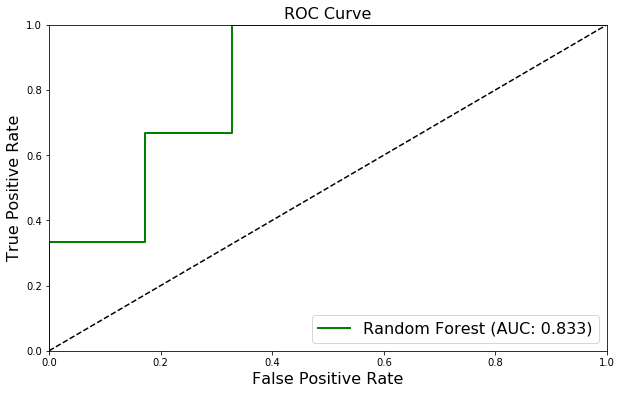

In [127]:
# ROC curve 
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
#plt.plot(fpr_lr,tpr_lr,label="Logistic Regression (AUC: {:.3f})".format(auc_lr),linewidth=2)
plt.plot(fpr_rf,tpr_rf,'g',label="Random Forest (AUC: {:.3f})".format(auc_rf),linewidth=2)
plt.xlabel("False Positive Rate",fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.title("ROC Curve",fontsize=16)
plt.legend(loc="lower right",fontsize=16) 

In [ ]:
measure = 'FCS'
cut = 'bad'
category = measure+'_binary_'+cut

df_test,df_train = year_split("tz", tz_village)
X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y("tz",df_test,df_train)

# baseline
y_prob,y_test  = rfCLF(X_train,y_train_category[category],X_test,y_test_category[category],prob=True)

### Precision-Recall Curve

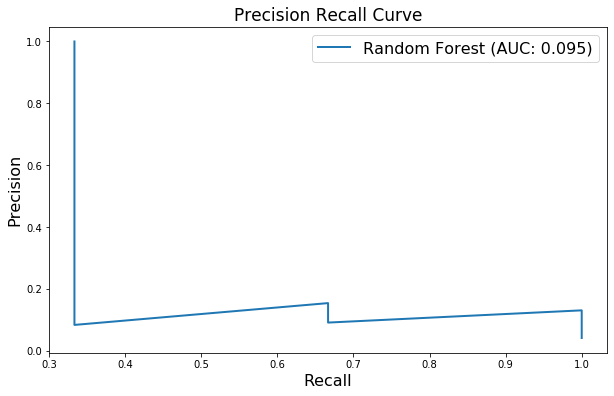

In [95]:
precision_rf,recall_rf,auc_rf = get_pr(y_prob,y_test)

plt.figure(figsize=(10,6))
#plt.plot(recall_lr,precision_lr,label="Logistic Regression (AUC: {:.3f})".format(auc_lr),linewidth=2)
plt.plot(recall_rf,precision_rf,label="Random Forest (AUC: {:.3f})".format(auc_rf),linewidth=2)
plt.xlabel("Recall",fontsize=16)
plt.ylabel("Precision",fontsize=16)
plt.title("Precision Recall Curve",fontsize=17)
plt.legend(fontsize=16)

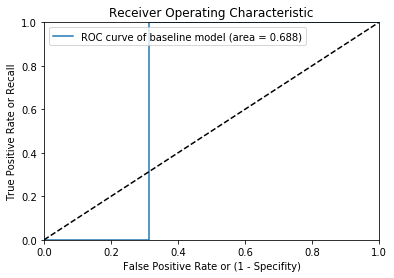

In [67]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of baseline model (area = %0.3f)' % roc_auc)

# Plot the grid
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="mider right")

#出现斜线/对角线，表示在你这两个threshold 之间，同时增加了TP和FP，
#也就是说，没有任何的trade off。一般造成这个情况有两个原因: 
#你有两个test样本在同一个threshold，但分别为正反例。

#你取的这两个threshold间距太大了。你可以加入一个中间值看看
#可能分类器过拟合，也有可能。


#在某些情况 下， ROC 曲线 不受 类别个数 影响 的 优点也是其缺点。
#正如 上述的例子中，当 负 样本增加了 10 倍 之后，从 ROC 曲线 上无法 反映 出 变化 。 
# 从下图的混淆 矩阵中， 我们可以 明显的看出两种情况下的区别。 可以 看到此时 实际为负，
#预测为正的样本 点大量增加（ 即 FP ） ， 这将导致 正 类的 精准率（ Precision ） 显着 的降低 。
# 从分类 报告中可以看到 正 类的 Precision 从 0.94 降低 到了 0.14 。
# 也就是 说，在 极 不平衡 的 数据集下， ROC 曲线会给出 一个 过于 乐观的 估计 

# precision-recall curve 

### Household level predictions

### Two category ROC curves

explore the relative distribution of our binary cases

In [37]:
print(mw_village[mw_village['FS_year']==2016].FCS_binary_bad.value_counts())
print(mw_village[mw_village['FS_year']==2016].rCSI_binary_bad.value_counts())

print(tz_village[tz_village['FS_year']>2013].FCS_binary_bad.value_counts())
print(tz_village[tz_village['FS_year']>2013].rCSI_binary_bad.value_counts())


print(ug_village[ug_village['FS_year']>2011].FCS_binary_bad.value_counts())

0    73
1     0
Name: FCS_binary_bad, dtype: int64
0    70
1     3
Name: rCSI_binary_bad, dtype: int64
0    48
1     1
Name: FCS_binary_bad, dtype: int64
0    47
1     2
Name: rCSI_binary_bad, dtype: int64
0    114
1      4
Name: FCS_binary_bad, dtype: int64


In [39]:
print(mw_village[mw_village['FS_year']<2016].FCS_binary_bad.value_counts())
print(mw_village[mw_village['FS_year']<2016].rCSI_binary_bad.value_counts())

print(tz_village[tz_village['FS_year']<2013].FCS_binary_bad.value_counts())
print(tz_village[tz_village['FS_year']<2013].rCSI_binary_bad.value_counts())


print(ug_village[ug_village['FS_year']<2011].FCS_binary_bad.value_counts())

0    286
1      7
Name: FCS_binary_bad, dtype: int64
0    292
1      1
Name: rCSI_binary_bad, dtype: int64
0    123
1      2
Name: FCS_binary_bad, dtype: int64
0    121
1      4
Name: rCSI_binary_bad, dtype: int64
0    155
1      8
Name: FCS_binary_bad, dtype: int64


In [99]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
    
def roc_curve_measure(country,df,measure,cut):
    
    category = measure+'_binary_'+cut
        
    df_test,df_train = year_split(country, df)
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)

    # baseline
    y_prob,y_test  = lrCLF(X_train,y_train_category[category],X_test,y_test_category[category],prob=True)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve of baseline model (area = %0.3f)' % roc_auc)
    
    # Tree
    y_prob,y_test  = treeCLF(X_train,y_train_category[category],X_test,y_test_category[category],prob=True)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve of Tree model (area = %0.3f)' % roc_auc)

    # rfc
    y_prob,y_test  = rfCLF (X_train,y_train_category[category],X_test,y_test_category[category],prob=True )
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve of Random Forest model (area = %0.3f)' % roc_auc)

    # XGB
    y_prob,y_test  = xgbCLF (X_train,y_train_category[category],X_test,y_test_category[category],prob=True )
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve of xgBOOST model (area = %0.3f)' % roc_auc)
    
    
    # Plot the grid
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or Recall')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="mider right")

    plt.savefig('output/graphs/roc/'+country+'_'+measure+cut+'_roc.png', bbox_inches='tight')


    return plt.show()

 

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.6s finished


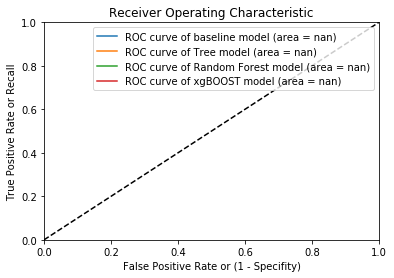

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished


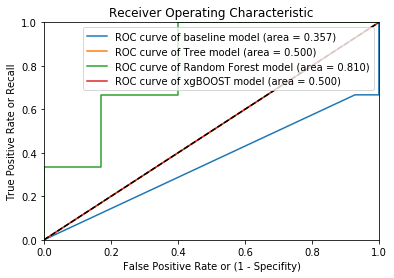

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  90 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished


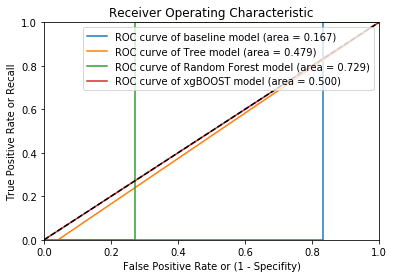

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  90 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished


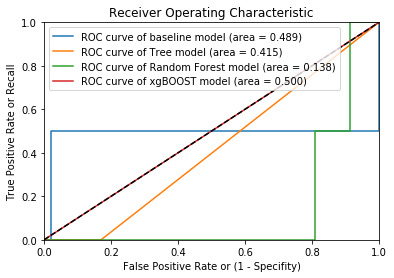

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.0s finished


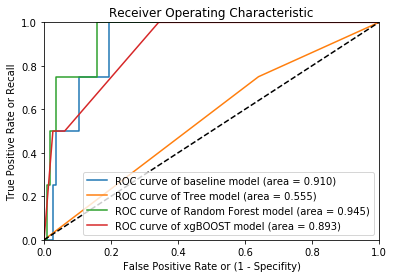

In [100]:
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for country in country_list:
    for measure in measure_list:
        if (measure=="rCSI") & (country=="ug"):
            pass
        else:
            if country=="mw":
                df = mw_village
            elif country == "ug":
                df = ug_village
            elif country == "tz":
                df = tz_village

            roc_curve_measure(country,df,measure,cut='bad')

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.7s finished


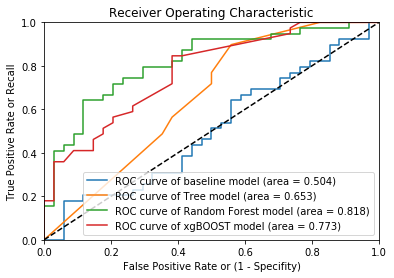

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  90 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished


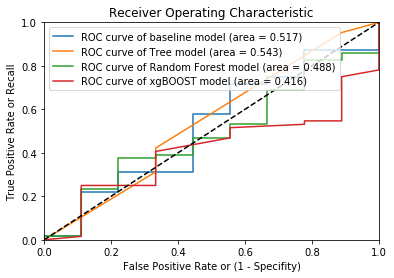

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  90 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished


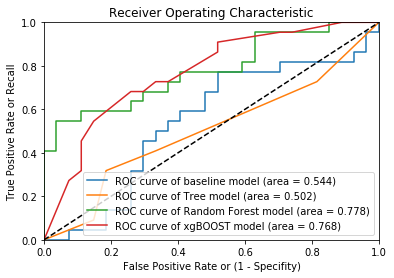

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  90 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished


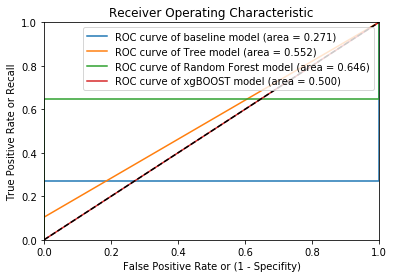

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished


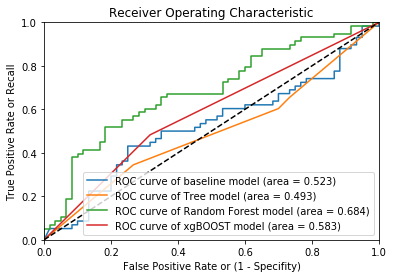

In [9]:
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for country in country_list:
    for measure in measure_list:
        if (measure=="rCSI") & (country=="ug"):
            pass
        else:
            if country=="mw":
                df = mw_village
            elif country == "ug":
                df = ug_village
            elif country == "tz":
                df = tz_village

            roc_curve_measure(country,df,measure,cut='safe')

### Percentage of insecure

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from scipy.stats import pearsonr

def lr(X_train,y_train,X_test, y_test):
    '''linear_reg'''
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    
    return y_test,y_pred

def lasso(X_train,y_train,X_test, y_test):
    '''lasso'''
    reg = LassoCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
                                0.3, 0.6, 1],
                        max_iter=500, cv=10).fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    
    return y_test,y_pred

def rf(X_train,y_train,X_test, y_test):
    '''rfc'''
    rf_reg = RandomForestRegressor(max_features='auto', n_estimators = 500,warm_start=True)

    max_depth = [int(x) for x in np.linspace(12, 30, num = 10)]
    max_features = [int(x) for x in np.linspace(8, 20, num = 10)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    rf_random = RandomizedSearchCV(estimator = rf_reg, 
            param_distributions = random_grid,
            refit ='recall', 
            n_iter = 30, cv = 3, verbose=0, random_state=666, 
            n_jobs = -1)


    # Fit the random search model
    rf_random.fit(X_train, y_train)
    
    y_pred = rf_random.predict(X_test)
    
    return y_test,y_pred

def xgb(X_train,y_train,X_test, y_test,prob=False):
    '''XGB'''

    # fit model on  training data
    XGB_reg = XGBRegressor(silent=False, 
                          scale_pos_weight=1,
                          learning_rate=0.3,  
                          colsample_bytree = 0.4,
                          subsample = 0.8,
                          objective='binary:logistic', 
                          #objective='multi:softmax', 
                          #num_class=14,
                          n_estimators=100, 
                          reg_alpha = 0.3,
                          max_depth=5, 
                          gamma=10)
   
    max_depth = [int(x) for x in np.linspace(2, 5, num = 10)]
    max_features = [int(x) for x in np.linspace(3, 20, num = 10)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    XGB_random = RandomizedSearchCV(estimator = XGB_reg, param_distributions = random_grid,
                                    n_iter = 30, cv = 3, verbose=0, random_state=666, n_jobs = -1)
    # Fit the random search model
    
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    
    XGB_random.fit(X_train, y_train)
    y_pred = XGB_random.predict(X_test)
         
    return y_test,y_pred
    
def r2_percent_low(country,df,measure,model):
    
    percent = measure+'_low_percent'
    
    df_test,df_train = year_split(country, df)
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    y_pred,y_test  = model(X_train,y_train_percent[percent],X_test,y_test_percent[percent])
    r2= round(pearsonr(y_pred,y_test)[0]**2,3)
    
    result_row = [[country,measure, model.__doc__, r2]]
    result_df = pd.DataFrame(result_row,columns = ['country','measure','model','r2']) 

    return result_df

def r2_percent_mid_low(country,df,measure,model):
    
    percent = measure+'mid+low'
    
    df_test,df_train = year_split(country, df)
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    y_pred,y_test  = model(X_train,y_train_percent[percent],X_test,y_test_percent[percent])
    r2= round(pearsonr(y_pred,y_test)[0]**2,3)    
    result_row = [[country,measure, model.__doc__, r2]]
    result_df = pd.DataFrame(result_row,columns = ['country','measure','model','r2']) 

    return result_df

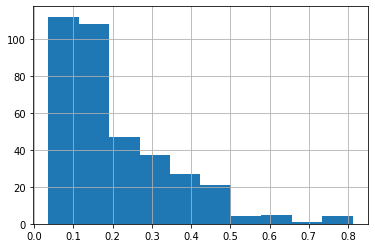

In [16]:
mw_village['FCS_low_percent'].hist()

In [7]:
percent_results_low = pd.DataFrame(columns = ['country','measure','model', 'r2']) 

model_list= [lr,lasso,rf,xgb]
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for model in model_list:
    for country in country_list:
        for measure in measure_list:
            if (measure=="rCSI") & (country=="ug"):
                pass
            else:
                if country=="mw":
                    df = mw_village
                elif country == "ug":
                    df = ug_village
                elif country == "tz":
                    df = tz_village
            
                percent_results_low = percent_results_low.append(r2_percent_low(country,df,measure,model),ignore_index=True)
percent_results_low                

,country,measure,model,r2
0,mw,FCS,linear_reg,0.073
1,mw,rCSI,linear_reg,0.003
2,tz,FCS,linear_reg,0.018
3,tz,rCSI,linear_reg,0.005
4,ug,FCS,linear_reg,0.002
5,mw,FCS,lasso,0.006
6,mw,rCSI,lasso,0.060
7,tz,FCS,lasso,0.001
8,tz,rCSI,lasso,0.044
9,ug,FCS,lasso,0.022


### Oversample for three class

In [20]:
from sklearn.utils import resample
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN


def upsample_minority(X_train,y_train,measure):
    
    category = measure + '_category'
    train_df = pd.concat([X_train, y_train[category]], axis=1)

    # separate minority and majority classes
    train_df_not_crisis = train_df[train_df[category]!=2]
    train_df_crisis = mw11_rCSI_df[train_df[category]==2]

    # upsample minority
    X_train_upsampled_minority = resample(train_df_crisis,replace=True, # sample with replacement
                                     n_samples=len(train_df_crisis), # match number in majority class
                                     random_state=27) # reproducible results
    
    # combine majority and upsampled minority
    X_train_upsampled = pd.concat([train_df_not_crisis,X_train_upsampled_minority])

    y_train_upsampled = X_train_upsampled[category]

    X_train_upsampled = X_train_upsampled.drop(category,axis=1)

    return X_train_upsampled,y_train_upsampled


def smote_minority(X_train,y_train,measure):
    
    category = measure + '_category'

    smt = SMOTETomek(random_state=42,sampling_strategy='minority')

    X_train_smote, y_train_smote = smt.fit_resample(X_train, y_train[category])

    # smt_non = SMOTETomek(random_state=42,sampling_strategy='not minority')
    
    return X_train_smote, y_train_smote 

def adasyn_minority(X_train,y_train,measure):

    category = measure + '_category'
    
    ada = ADASYN(random_state=42,n_jobs=5,sampling_strategy='minority')

    X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train[category])
    
    return X_train_ada, y_train_ada 

def metrics_severe_upsample(country,df,measure,model,method):
    
    category = measure+'_3_category'
    
    df_test,df_train = year_split(country, df)
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    
    if method == "upsample":
        X_train_upsampled,y_train_upsampled = upsample_minority(X_train,y_train_category[category],measure)
    elif method == "smote":
        X_train_upsampled,y_train_upsampled = smote_minority(X_train,y_train_category[category],measure)
    elif method == "adasyn":
        X_train_upsampled,y_train_upsampled = adasyn_minority(X_train,y_train_category[category],measure)
    
    y_pred,y_test  = model(X_train_upsampled,y_train_upsampled[category],X_test,y_test_category[category])
    
    precision,recall,fscore,support,accuracy = pre_rec_f1_support_minority(y_pred,y_test)
    
    result_row = [[country,measure, model.__doc__, precision,recall,fscore,support,accuracy]]
    result_df = pd.DataFrame(result_row,columns = ['country','measure','model', 'precision','recall','fscore','support','accuracy']) 

    return result_df


In [21]:
# create a table of results for the third category

third_category_oversample = pd.DataFrame(columns = ['country','measure','model', 'precision','recall','fscore','support','accuracy']) 

model_list= [lrCLF,treeCLF,rfCLF,xgbCLF]
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]
method_list = ["upsample","smote","adasyn"]

for method in method_list:
    for model in model_list:
        for country in country_list:
            for measure in measure_list:
                if (measure=="rCSI") & (country=="ug"):
                    pass
                else:
                    if country=="mw":
                        df = mw_village
                    elif country == "ug":
                        df = ug_village
                    elif country == "tz":
                        df = tz_village

                    third_category_oversample = third_category_oversample.append(metrics_severe_upsample(country,df,measure,model,method),ignore_index=True)

KeyError: 'FCS_category'

### Feature importance

In [25]:
tree_clf = DecisionTreeClassifier(random_state=66)
    
max_depth = [int(x) for x in np.linspace(3, 20, num = 10)]
max_features = [int(x) for x in np.linspace(3, 20, num = 10)]
# n_estimators = [int(x) for x in np.linspace(1, 10, num = 5)]

random_grid = {#'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth
                #'min_samples_split': min_samples_split
                #'min_samples_leaf': min_samples_leaf}
                #'bootstrap': bootstrap
                }

tree_random = RandomizedSearchCV(estimator = tree_clf, param_distributions = random_grid,
                                n_iter = 30, cv = 3, verbose=2, random_state=666, n_jobs = -1)

X_train = mw_clust_X_train_16
y_train = mw_clust_y_train_16['FCS_category']
tree_random.fit(X_train, y_train)

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree_random.best_estimator_, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


NameError: name 'mw_clust_X_train_16' is not defined

In [ ]:
rf_clf = RandomForestClassifier(max_features='auto', n_estimators = 100,min_samples_split=10,warm_start=True)

        
# Define rfc classifier
max_depth = [int(x) for x in np.linspace(12, 30, num = 10)]
max_features = [int(x) for x in np.linspace(8, 20, num = 10)]

random_grid = {#'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth
              #'min_samples_split': min_samples_split
              #'min_samples_leaf': min_samples_leaf}
              #'bootstrap': bootstrap
              }

rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = random_grid,
                              n_iter = 30, cv = 3, verbose=2, random_state=666, n_jobs = -1)


# Fit the random search model
rf_random.fit(X_train, y_train)

### Error Analysis

In [ ]:
ug12 = pd.DataFrame({ 'ug12_FCS_truth':ug12_FCS_truth, 'ug_FCS_LR' : ug12_FCS_LR, 'ug_FCS_RFC' : ug12_FCS_RFC}).reset_index(drop=True)
ug_map = pd.concat([ug_ea_id.reset_index(drop=True),ug12 ], axis=1, ignore_index=True)
ug_map.columns=['ea_id','FS_year','lat_modified','lon_modified','ug12_FCS_truth','ug_FCS_LR','ug_FCS_RFC']



### Three category results 


In [ ]:
def pre_rec_f1_support_minority(y_pred,y_test):
    
    if len(precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[3])==3:
        precision = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[0][2]
        recall = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[1][2]
        fscore = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[2][2]
        support = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[3][2]

    elif len(precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[3])==2:
 #   precision = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[0][1]
 #   recall = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[1][1]
 #   fscore = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[2][1]
 #   support = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[3][1]

        precision = np.nan
        recall = np.nan
        fscore = np.nan
        support = np.nan

    accuracy = accuracy_score(y_pred,y_test)

    return precision,recall,fscore,support,accuracy    
 
def pre_rec_f1_support_mid(y_pred,y_test):

    precision = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[0][1]
    recall = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[1][1]
    fscore = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[2][1]
    support = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[3][1]
    accuracy = accuracy_score(y_pred,y_test)

    return precision,recall,fscore,support,accuracy        

def metrics_3_category_severe(country,df,measure,model):
    
    category = measure+'_3_category'
    
    df_test,df_train = year_split(country, df)
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    y_pred,y_test  = model(X_train,y_train_category[category],X_test,y_test_category[category])
    
    precision,recall,fscore,support,accuracy = pre_rec_f1_support_minority(y_pred,y_test)
    
    result_row = [[country,measure, model.__doc__, precision,recall,fscore,support,accuracy]]
    result_df = pd.DataFrame(result_row,columns = ['country','measure','model', 'precision','recall','fscore','support','accuracy']) 

    return result_df

def metrics_3_category_mid(country,df,measure,model):
    
    category = measure+'_3_category'
    
    df_test,df_train = year_split(country, df)
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    y_pred,y_test  = model(X_train,y_train_category[category],X_test,y_test_category[category])
    
    precision,recall,fscore,support,accuracy = pre_rec_f1_support_mid(y_pred,y_test)
    
    result_row = [[country,measure, model.__doc__, precision,recall,fscore,support,accuracy]]
    result_df = pd.DataFrame(result_row,columns = ['country','measure','model', 'precision','recall','fscore','support','accuracy']) 

    return result_df

# create a table of results for the third category

third_category_severe = pd.DataFrame(columns = ['country','measure','model', 'precision','recall','fscore','support','accuracy']) 

model_list= [lrCLF,treeCLF,rfCLF,xgbCLF]
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for model in model_list:
    for country in country_list:
        for measure in measure_list:
            if (measure=="rCSI") & (country=="ug"):
                pass
            else:
                if country=="mw":
                    df = mw_village
                elif country == "ug":
                    df = ug_village
                elif country == "tz":
                    df = tz_village
            
                third_category_severe = third_category_severe.append(metrics_3_category_severe(country,df,measure,model),ignore_index=True)
                
# create a table of results for the third category

third_category_mid= pd.DataFrame(columns = ['country','measure','model', 'precision','recall','fscore','support','accuracy']) 

model_list= [lrCLF,treeCLF,rfCLF,xgbCLF]
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for model in model_list:
    for country in country_list:
        for measure in measure_list:
            if (measure=="rCSI") & (country=="ug"):
                pass
            else:
                if country=="mw":
                    df = mw_village
                elif country == "ug":
                    df = ug_village
                elif country == "tz":
                    df = tz_village
            
                third_category_mid = third_category_mid.append(metrics_3_category_mid(country,df,measure,model),ignore_index=True)                